In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import retrieval_scripts.retrieval_311
import census_data_311
import geopandas as gpd
import os

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
df = retrieval_311.bulk_download_311()

Data available locally


In [4]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [5]:
# variables: https://api.census.gov/data/2019/acs/acs5/variables.html
hispanic = [f'B03002_0{i:02d}E' for i in range(1, 13)]
other_vars = ['B01003_001E',
              'B19013_001E', # median income
              'B01002_001E', # 
              'B25024_001E', # total structures
              'B25024_002E' # single family homes
              ]
fields = hispanic + other_vars
census_df = census_data_311.get_census_data(fields)
sf_df = census_data_311.clean_variable_names(census_df, fields)

In [6]:
shape_url = "https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip"
path = "sf_shapes/sf_county_farallon.shp"

sf_county_farallon = census_data_311.open_sf_shape(shape_url, path)

Opening local file...
Done


In [7]:
sf_merge = sf_county_farallon.merge(sf_df, on = "GEOID", how="inner")

In [8]:
sf_merge = sf_merge[sf_merge['Total'] >= 1]
gdf = gdf[gdf['Latitude'] != 0]

In [9]:
sf_merge.crs = "epsg:4326"
gdf.crs = "epsg:4326"

In [10]:
land_populated_df = census_data_311.remove_water(sf_merge)

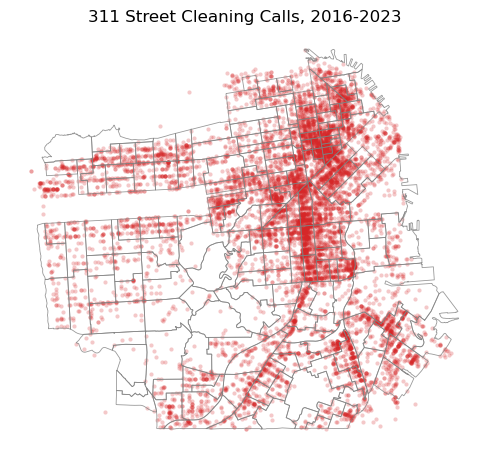

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("311 Street Cleaning Calls, 2016-2023")
land_populated_df.exterior.plot(linewidth=.6, color='grey', alpha=.8, ax=ax)
gdf.sample(10000).plot(ax=ax, color="tab:red", marker=".", alpha=.25, linewidth=0)
ax.set_axis_off()
fig.tight_layout()
fig.savefig("figures/311_map.png", dpi=300)

In [12]:
for col in land_populated_df.columns:
    if col.startswith("Total_Not_Hispanic_or_Latino"):
        land_populated_df[col+"%"] = land_populated_df[col] / land_populated_df['Total_Not_Hispanic_or_Latino']
    elif col.startswith("Total_Hispanic_or_Latino"):
        land_populated_df[col+"%"] = land_populated_df[col] / land_populated_df['Total']


In [13]:
jointracts = gpd.sjoin(left_df=gdf,
                       right_df=land_populated_df,
                       how='left')


In [18]:
jointracts['datetime'] = pd.to_datetime(jointracts['Opened'],format="%m/%d/%Y %I:%M:%S %p")

In [19]:
jointracts = jointracts[(jointracts['datetime'].dt.year > 2008) & (jointracts['datetime'].dt.year < 2023)]

In [23]:
jointracts['date'] = jointracts['datetime'].dt.date
jointracts['hour'] = jointracts['datetime'].dt.hour
jointracts['year'] = jointracts['datetime'].dt.year

c:\Users\peteramerkhanian\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\peteramerkhanian\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\peteramerkhanian\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [50]:
grouped_df = jointracts.groupby(['GEOID', 'datetime']).size().reset_index()

In [60]:
grouped_df = grouped_df.rename(columns={0: 'calls'})
grouped_df = grouped_df.set_index("datetime")

In [66]:
n_steps = 48

In [81]:
def evaluate_fit(test_preds, actual_calls, verbose=True):
    rmse = np.mean((actual_calls - test_preds)**2)**.5
    r2 = r2_score(actual_calls, test_preds)
    max_resid = np.max(np.abs(actual_calls - test_preds))
    if verbose:
        print("rmse", rmse)
        print("r2", r2)
        print("max resid", max_resid)
    return rmse, r2, max_resid

In [196]:
tract_level_accuracy = {}

print("----- Regression With Lags -----")
for geoid in grouped_df['GEOID'].unique():
    tract_level_accuracy[geoid] = []
    # print(geoid)
    tract = grouped_df[grouped_df['GEOID'] == geoid]
    tract = tract.resample('1H')[['calls']].count()
    X_ = tract.copy()[['calls']]
    for i in range(1, n_steps+1):
        X_[f'lag_{i}'] = X_['calls'].shift(i)
    X_ = X_.dropna()
    all_years = X_.index.year.unique()

    rmses = []
    r2s = []
    max_resids = []
    for i in range(len(all_years)-2):
        # print(all_years[i], "-->", all_years[i+1])
        train_data = X_[X_.index.year == all_years[i]].diff(1).dropna()
        test_data = X_[X_.index.year == all_years[i+1]].diff(1).dropna()

        X_train = train_data.drop('calls', axis=1).values
        y_train = train_data[['calls']].values
        X_test = test_data.drop('calls', axis=1).values
        y_test = test_data[['calls']].values

        scaler_X = StandardScaler()
        scaler_X.fit(X_train)
        scaler_y = StandardScaler()
        scaler_y.fit(y_train)

        X_train_scaled = scaler_X.transform(X_train)
        y_train_scaled = scaler_y.transform(y_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_test_scaled = scaler_y.transform(y_test)

        X_train_scaled = np.clip(X_train_scaled, -3, 3)
        X_test_scaled = np.clip(X_test_scaled, -3, 3)

        lm = LinearRegression()
        lm.fit(X_train_scaled, y_train_scaled)
        test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled))
        actual_calls = y_test
        rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls, verbose=False)
        rmses.append(rmse)
        r2s.append(r2)
        max_resids.append(max_resid)
    # print("Mean RMSE:", np.mean(rmses))
    # print("Mean r2:", np.mean(r2s))
    # print("Max resid:", np.mean(max_resids))
    tract_level_accuracy[geoid].append(np.mean(rmses))
    tract_level_accuracy[geoid].append(np.mean(r2s))
    tract_level_accuracy[geoid].append(np.mean(max_resids))

06075010100
06075010200
06075010300
06075010400
06075010500
06075010600
06075010700
06075010800
06075010900
06075011000
06075011100
06075011200
06075011300
06075011700
06075011800
06075011901
06075011902
06075012000
06075012100
06075012201
06075012202
06075012301
06075012302
06075012401
06075012402
06075012501
06075012502
06075012601
06075012602
06075012700
06075012800
06075012901
06075012902
06075013000
06075013101
06075013102
06075013200
06075013300
06075013400
06075013500
06075015100
06075015200
06075015300
06075015400
06075015500
06075015600
06075015700
06075015801
06075015802
06075015900
06075016000
06075016100
06075016200
06075016300
06075016400
06075016500
06075016600
06075016700
06075016801
06075016802
06075016900
06075017000
06075017101
06075017102
06075017601
06075017700
06075017801
06075017802
06075017902
06075018000
06075020100
06075020200
06075020300
06075020401
06075020402
06075020500
06075020600
06075020700
06075020800
06075020900
06075021000
06075021100
06075021200
0607

In [197]:
tract_performance = pd.DataFrame(tract_level_accuracy).T

In [198]:
tract_performance.columns = ["rmse", "r^2", "max_residual"]
tract_performance = tract_performance.reset_index()

In [199]:
performance_with_shape = sf_merge[['GEOID', 'geometry']].merge(tract_performance, left_on="GEOID", right_on="index")

In [200]:
performance_with_shape.to_csv("figures/OLS_tract_performance.csv")

In [201]:
print(performance_with_shape.describe())

,rmse,r^2,max_residual
count,195.000000,195.000000,195.000000
mean,0.356810,0.363838,5.629808
std,0.198273,0.028405,2.593321
min,0.034689,0.296330,1.249989
25%,0.222780,0.345506,3.968565
50%,0.312387,0.361892,4.998453
75%,0.445014,0.379407,6.507899
max,1.346663,0.477913,18.273830


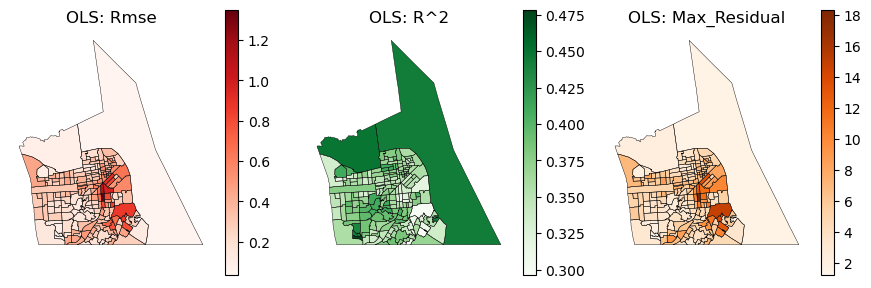

In [178]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
count = 0
colors = ["Reds", "Greens", "Oranges"]
for measure in ["rmse", "r^2", "max_residual"]:
    performance_with_shape.plot(measure, legend=True, cmap=colors[count], ax=axes[count],)
    performance_with_shape.exterior.plot(linewidth=.3, color="black", ax=axes[count])
    axes[count].set_axis_off()
    axes[count].set_title("OLS: " + measure.title())
    count += 1
fig.tight_layout()
fig.savefig("figures/geospatial_performance_OLS.png", dpi=300)

In [181]:
tract_level_accuracy = {}
print("----- RF With Lags -----")

for geoid in grouped_df['GEOID'].unique():
    tract_level_accuracy[geoid] = []
    # print(geoid)
    tract = grouped_df[grouped_df['GEOID'] == geoid]
    tract = tract.resample('1H')[['calls']].count()
    X_ = tract.copy()[['calls']]
    for i in range(1, n_steps+1):
        X_[f'lag_{i}'] = X_['calls'].shift(i)
    X_ = X_.dropna()
    all_years = X_.index.year.unique()

    rmses = []
    r2s = []
    max_resids = []
    for i in range(len(all_years)-2):
        # print(all_years[i], "-->", all_years[i+1])
        train_data = X_[X_.index.year == all_years[i]].diff(1).dropna()
        test_data = X_[X_.index.year == all_years[i+1]].diff(1).dropna()

        X_train = train_data.drop('calls', axis=1).values
        y_train = train_data[['calls']].values
        X_test = test_data.drop('calls', axis=1).values
        y_test = test_data[['calls']].values

        scaler_X = StandardScaler()
        scaler_X.fit(X_train)
        scaler_y = StandardScaler()
        scaler_y.fit(y_train)

        X_train_scaled = scaler_X.transform(X_train)
        y_train_scaled = scaler_y.transform(y_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_test_scaled = scaler_y.transform(y_test)

        X_train_scaled = np.clip(X_train_scaled, -3, 3)
        X_test_scaled = np.clip(X_test_scaled, -3, 3)

        y_train_scaled = y_train_scaled.flatten()
        y_test_scaled = y_test_scaled.flatten()

        lm = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        lm.fit(X_train_scaled, y_train_scaled)
        test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled).reshape(-1, 1))
        actual_calls = y_test
        rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls, verbose=False)
        rmses.append(rmse)
        r2s.append(r2)
        max_resids.append(max_resid)
    # print("Mean RMSE:", np.mean(rmses))
    # print("Mean r2:", np.mean(r2s))
    # print("Max resid:", np.mean(max_resids))
    tract_level_accuracy[geoid].append(np.mean(rmses))
    tract_level_accuracy[geoid].append(np.mean(r2s))
    tract_level_accuracy[geoid].append(np.mean(max_resids))

06075010100
06075010200
06075010300
06075010400
06075010500
06075010600
06075010700
06075010800
06075010900
06075011000
06075011100
06075011200
06075011300
06075011700
06075011800
06075011901
06075011902
06075012000
06075012100
06075012201
06075012202
06075012301
06075012302
06075012401
06075012402
06075012501
06075012502
06075012601
06075012602
06075012700
06075012800
06075012901
06075012902
06075013000
06075013101
06075013102
06075013200
06075013300
06075013400
06075013500
06075015100
06075015200
06075015300
06075015400
06075015500
06075015600
06075015700
06075015801
06075015802
06075015900
06075016000
06075016100
06075016200
06075016300
06075016400
06075016500
06075016600
06075016700
06075016801
06075016802
06075016900
06075017000
06075017101
06075017102
06075017601
06075017700
06075017801
06075017802
06075017902
06075018000
06075020100
06075020200
06075020300
06075020401
06075020402
06075020500
06075020600
06075020700
06075020800
06075020900
06075021000
06075021100
06075021200
0607

In [182]:
tract_performance = pd.DataFrame(tract_level_accuracy).T

In [183]:
tract_performance.columns = ["rmse", "r^2", "max_residual"]
tract_performance = tract_performance.reset_index()

In [184]:
performance_with_shape = sf_merge[['GEOID', 'geometry']].merge(tract_performance, left_on="GEOID", right_on="index")

In [186]:
performance_with_shape.to_csv("figures/RF_tract_performance.csv")

In [195]:
print(performance_with_shape.describe())

,rmse,r^2,max_residual
count,195.000000,195.000000,195.000000
mean,0.368088,0.323568,5.659018
std,0.201285,0.044890,2.619272
min,0.035049,0.150242,1.249182
25%,0.229985,0.297091,3.946835
50%,0.327233,0.316827,5.017351
75%,0.455790,0.344848,6.511503
max,1.300084,0.471582,18.045079


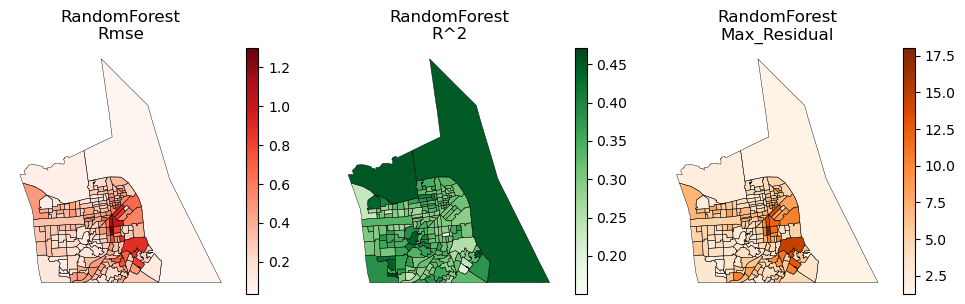

In [193]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
count = 0
colors = ["Reds", "Greens", "Oranges"]
for measure in ["rmse", "r^2", "max_residual"]:
    performance_with_shape.plot(measure, legend=True, cmap=colors[count], ax=axes[count],)
    performance_with_shape.exterior.plot(linewidth=.3, color="black", ax=axes[count])
    axes[count].set_axis_off()
    axes[count].set_title("RandomForest\n" + measure.title())
    count += 1
fig.tight_layout()
fig.savefig("figures/geospatial_performance_RF.png", dpi=300)